In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import random
import stim
import stim_model
import cpn_model
import utils


# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

In [2]:
# Problem 1:
# We will recapitulate sine waves with various starting
# phases. 'steps' is the trial length
steps = 200
batch_size = 256
# y=target, x=phase
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    offset = bidx / float(batch_size)
    for i in range(steps):
        t = torch.tensor(6 * (i / 100.0) + offset)
        target[bidx, i, 0] = torch.sin(t)
        target[bidx, i, 1] = t
        
target = target[torch.randperm(target.shape[0]), :, :]

In [6]:
# Problem 2:
# Alternate, more difficult problem that involves memory.
# Learning isn't working here yet.
# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 100
show_steps = 10
hold_steps = 20
batch_size = 256
# y=target, x=(target freq, hold signal)
target = torch.zeros((batch_size, steps, 3))
for bidx in range(batch_size):
    freq = bidx * 15 / float(batch_size) + 2
    x = bidx / float(batch_size)
    for i in range(steps):     
        # This is a harder problem involving memory, which looks
        # a lot like the the Michaels problem
        # Dim 1: the target value
        if i < hold_steps:
            target[bidx, i, 0] = 0.0
        else:
            t = torch.tensor(freq * ((i - hold_steps)/ 100.0))
            target[bidx, i, 0] = torch.sin(t)
        
        # Dim 2: the target freq
        if i < show_steps:
            target[bidx, i, 1] = torch.tensor(x)
        else:
            target[bidx, i, 1] = 0.0
            
        # Dim 3: the hold signal
        if i < hold_steps:
            target[bidx, i, 2] = 1.0
        else:
            target[bidx, i, 2] = 0.0

In [7]:
# Train a BEN on a collection of CPNs, centered at the given CPN,
#  with mean 0 noise added to the weights.

      
def make_noised_cpn(cpn, var=0.1):
    cpn_out = cpn_model.CPNModel(cpn.in_dim, cpn.out_dim, num_neurons=cpn.num_neurons,
                                 activation_func=cpn.activation_func_t)
    cpn_out.load_state_dict(cpn.state_dict())
    
    with torch.no_grad():
        for p in cpn_out.parameters():
            noise = var * (torch.rand(p.shape) - 0.5)
            p.data = p.data + p.data * noise
            
    return cpn_out

def train_a_ben(cpn, ben=None, last_loss=1):
    global recent_ben
    
    # An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'x'
    if ben is None or last_loss > 0.05:
        ben = stim_model.StimModel(target.shape[-1] + 1, 1, num_neurons=70,
                                   activation_func=torch.nn.Tanh)
        recent_ben = ben
    vl = torch.ones(1)
    opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
    loss = torch.nn.MSELoss()

    checkpoint_eidx = 0
    for eidx in range(10000000):
        ben.reset()
        cpn.reset()
        opt_ben.zero_grad()
        all_obs = torch.zeros(batch_size, steps, requires_grad=False)
        preds = torch.zeros(batch_size, steps)
        
        for p in opt_ben.param_groups:
            if eidx < 3:
                p['lr'] = 5e-3
            else:
                p['lr'] = min(max(1e-4, 0.4192 * vl.item()), 3e-3)
    
        random_targets = target[torch.randperm(target.shape[0]), :, :]
        cpn_noise = cpn_model.CPNNoiseyCollection(cpn, noise_var=(0.1 * last_loss))
        # Just in case...
        for param in cpn_noise.parameters():
            param.requires_grad=False
            
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn_noise(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        rl = loss(preds, all_obs)
        rl.backward()
        opt_ben.step()
        
        # Verify against the actual CPN
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        obs_val = torch.zeros(batch_size, steps)
        preds_val = torch.zeros(batch_size, steps)
        cpn.reset()
        ben.reset()
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs).reshape(256,1)
            obs_val[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds_val[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            obs = []
            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        vl = loss(preds_val, obs_val)
        print("ben", eidx, rl.item(), "first 80:",
              loss(preds[:80, :], all_obs[:80, :]).item(),
              "val:", vl.item())
                
        if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
            # Emergency eject button
            ben = stim_model.StimModel(ben.in_dim, ben.out_dim, num_neurons=ben.num_neurons,
                                       activation_func=ben.activation_func_t)
            recent_ben = ben
            opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
            checkpoint_eidx = eidx
            
        if vl.item() < max(0.01 * last_loss, 0.0007) and eidx > 200:
            break
            
    return ben

In [ ]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.


#  1 dimension of stim param, output
cpn = cpn_model.CPNModel(target.shape[-1], 1, num_neurons=70, activation_func=torch.nn.PReLU)
opt_cpn = AdamW(cpn.parameters(), lr=2e-3)

loss = torch.nn.MSELoss()

rli = 1

ben_losses = []
cpn_losses = []
bens = []
ben = 0.159
while True:

    for param in cpn.parameters():
        param.requires_grad=False
    # @preston: retraining an existing ben doesn't work - it never converges.
    #ben = train_a_ben(cpn, ben=ben, last_loss=rli)
    ben = train_a_ben(cpn, last_loss=rli)
    bens.append(ben)
    for param in cpn.parameters():
        param.requires_grad=True
    for param in ben.parameters():
        param.requires_grad=False
        
    recent_losses = []
    for eidx in range(400):
        cpn.reset()
        ben.reset()
        opt_cpn.zero_grad()
    
        thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]
    
        pred = torch.zeros((256, steps))
        # This is actually very simple in our single variable context: it outputs
        # a stimulation value which decays to 0 over time.
        # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
        #  the purpose of applying to the Michaels model. I may remove it later.
        s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    
        all_obs = torch.zeros(256, steps)
        stims = []

        for tidx in range(steps):
            obs = [t.observe() for t in thing]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
            new_stim.retain_grad()
        
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            pred[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            stims.append(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                thing[bidx].step(n[bidx, 0].item())

            
        rl = loss(pred, target[:, :, 0])
        rli = rl.item()
        rl.backward()  

        real_loss = loss(all_obs, target[:, :, 0])
        print("cpn", eidx, rl.item(), loss(pred, all_obs).item(), real_loss.item())
        recent_losses.append(real_loss)
                                        
        # Emergency bailout; we diverged; start over :(
        if recent_losses[-1] > 1.5:
            cpn = cpn_model.CPNModel(target.shape[-1], cpn.out_dim,
                                     num_neurons=cpn.num_neurons,
                                     activation_func=cpn.activation_func_t)
            opt_cpn = AdamW(cpn.parameters(), lr=2e-3)
            break
            
        # Emergency bailout; time to retrain ben
        if len(recent_losses) > 12 and (recent_losses[-1] > recent_losses[0] * 1.2):
            ben = None
            break
        # Done
        elif rli < 0.003:
            break
        elif len(recent_losses) > 12:
            prev = None
            num_regressed = 0
            for l in recent_losses[-12:]:
                if prev is not None and l > prev:
                    num_regressed += 1
                        
                prev = l
            
            if num_regressed > 3 and loss(pred, all_obs).item() > rli or num_regressed > 5:
                if eidx < 20:
                    ben = None
                break
              
        cpn_losses.append(rli)
        opt_cpn.step()
        
    if rli < 0.003:
        break

plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0, :, 0].detach().numpy())
plt.show()

ben 0 0.47186732292175293 first 80: 0.496011346578598 val: 0.005898245144635439
ben 1 0.033339597284793854 first 80: 0.029597746208310127 val: 0.13805101811885834
ben 2 0.1502661556005478 first 80: 0.1459604948759079 val: 0.1350095421075821
ben 3 0.1453355848789215 first 80: 0.15295474231243134 val: 0.0745299831032753
ben 4 0.09094296395778656 first 80: 0.09478021413087845 val: 0.020639711990952492
ben 5 0.03280691057443619 first 80: 0.035445988178253174 val: 0.005043823271989822
ben 6 0.017324846237897873 first 80: 0.020579388365149498 val: 0.014450686052441597
ben 7 0.029363231733441353 first 80: 0.026781965047121048 val: 0.03064732998609543
ben 8 0.04031180217862129 first 80: 0.03793903812766075 val: 0.03324858844280243
ben 9 0.043471381068229675 first 80: 0.03734595328569412 val: 0.023210948333144188
ben 10 0.0349360927939415 first 80: 0.038321517407894135 val: 0.010756858624517918
ben 11 0.02178097702562809 first 80: 0.025542208924889565 val: 0.003938374109566212
ben 12 0.01161146

ben 96 0.001570208347402513 first 80: 0.0015801573172211647 val: 0.0010213132482022047
ben 97 0.0018146444344893098 first 80: 0.0017428591381758451 val: 0.001012957189232111
ben 98 0.0014781985664740205 first 80: 0.0013435418950393796 val: 0.0010051256977021694
ben 99 0.0016536929178982973 first 80: 0.0015104166232049465 val: 0.000997732044197619
ben 100 0.001690984470769763 first 80: 0.0016587896971032023 val: 0.0009908188367262483
ben 101 0.0017718872986733913 first 80: 0.002055096672847867 val: 0.0009841270511969924
ben 102 0.00155322952196002 first 80: 0.0015808796742931008 val: 0.0009778724052011967
ben 103 0.0014651946257799864 first 80: 0.0016794828698039055 val: 0.0009710753802210093
ben 104 0.0014919672394171357 first 80: 0.0016441403422504663 val: 0.00096467713592574
ben 105 0.0014795224415138364 first 80: 0.001625493518076837 val: 0.0009583167848177254
ben 106 0.0016498272307217121 first 80: 0.0018495612312108278 val: 0.0009516081190668046
ben 107 0.0014608935452997684 first

ben 189 0.0009900662116706371 first 80: 0.0010304056340828538 val: 0.0005933551001362503
ben 190 0.0010754496324807405 first 80: 0.0011978605762124062 val: 0.0005909749306738377
ben 191 0.0010760936420410872 first 80: 0.000839599350001663 val: 0.0005886938888579607
ben 192 0.0010059281485155225 first 80: 0.0011242921464145184 val: 0.0005864959093742073
ben 193 0.0009701434755697846 first 80: 0.0009113842970691621 val: 0.0005840359372086823
ben 194 0.0011017421493306756 first 80: 0.0011303037172183394 val: 0.0005818031495437026
ben 195 0.0010877138702198863 first 80: 0.001239932607859373 val: 0.0005794677999801934
ben 196 0.0009572008275426924 first 80: 0.0010851806728169322 val: 0.0005771812284365296
ben 197 0.0009892858797684312 first 80: 0.0011520975967869163 val: 0.0005749434349127114
ben 198 0.0009739611414261162 first 80: 0.0010933410376310349 val: 0.0005727051175199449
ben 199 0.001060708425939083 first 80: 0.0008643336477689445 val: 0.0005708893877454102
ben 200 0.00127314741257

ben 72 0.0011760995257645845 first 80: 0.0013198687229305506 val: 0.0007748843636363745
ben 73 0.001072532031685114 first 80: 0.001078866538591683 val: 0.000767791410908103
ben 74 0.0012127525405958295 first 80: 0.001206014072522521 val: 0.0007616226212121546
ben 75 0.0011344989761710167 first 80: 0.0012591774575412273 val: 0.0007561413221992552
ben 76 0.0015211557038128376 first 80: 0.002538454020395875 val: 0.0007511345902457833
ben 77 0.0014354139566421509 first 80: 0.0012656903127208352 val: 0.0007467169198207557
ben 78 0.0011746344389393926 first 80: 0.001000541145913303 val: 0.0007418101304210722
ben 79 0.0011402354575693607 first 80: 0.0010522458469495177 val: 0.0007357749855145812
ben 80 0.000992641900666058 first 80: 0.0009506557835265994 val: 0.0007286535110324621
ben 81 0.00107587652746588 first 80: 0.0010313508100807667 val: 0.0007212110795080662
ben 82 0.000941140518989414 first 80: 0.0009100568131543696 val: 0.0007122305687516928
ben 83 0.0009510453674010932 first 80: 0.0

ben 165 0.0006753663765266538 first 80: 0.0008701618062332273 val: 0.00037754676304757595
ben 166 0.001582872704602778 first 80: 0.0005755667807534337 val: 0.00037577346665784717
ben 167 0.0005810173461213708 first 80: 0.0005233142292127013 val: 0.00037364475429058075
ben 168 0.0005911077023483813 first 80: 0.0006622322252951562 val: 0.0003714161866810173
ben 169 0.0005919007817283273 first 80: 0.000547727569937706 val: 0.00036915886448696256
ben 170 0.0015645383391529322 first 80: 0.0037450557574629784 val: 0.0003671034355647862
ben 171 0.000700606731697917 first 80: 0.0005508445901796222 val: 0.00036515845567919314
ben 172 0.0006023725145496428 first 80: 0.000563065696042031 val: 0.00036328285932540894
ben 173 0.0006122075719758868 first 80: 0.0006985064828768373 val: 0.00036151884705759585
ben 174 0.0011676849098876119 first 80: 0.0025747683830559254 val: 0.00035997387021780014
ben 175 0.0006559976027347147 first 80: 0.0005241648177616298 val: 0.0003585848317015916
ben 176 0.0006532

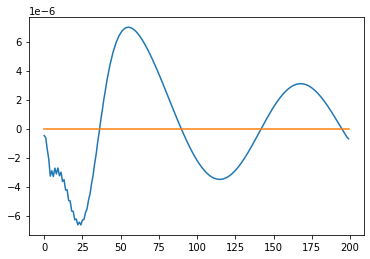

In [27]:
plt.plot([s.grad[0].item() for s in stims])
plt.plot([0.0 for s in stims])

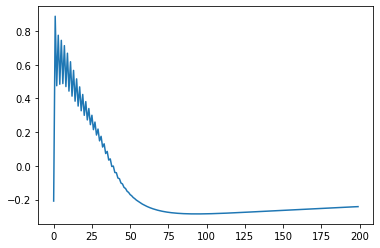

In [26]:
plt.plot([s[0].item() for s in stims])

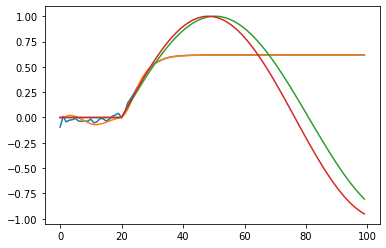

In [18]:
plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0,:,0].detach().numpy())
plt.show()


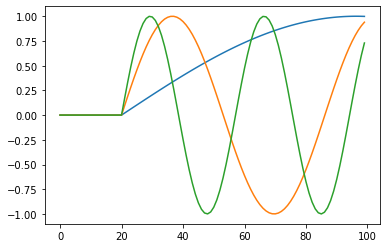

In [22]:
plt.plot(target[1,:,0].detach().numpy())
plt.plot(target[128,:,0].detach().numpy())

plt.plot(target[-1,:,0].detach().numpy())


1.542486548423767
7.755722522735596
3.3207645416259766


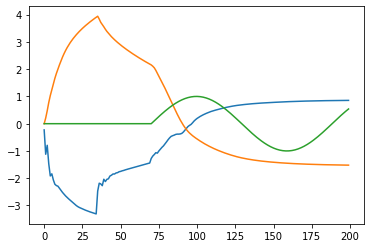

In [10]:
# Check fit of current ben and cpn
ben = recent_ben
cpn.reset()
ben.reset()

stims = []
pred = torch.zeros(batch_size, steps)
all_obs = torch.zeros(batch_size, steps)
noised = make_noised_cpn(cpn)
s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]

#cpn_temp = CPNNoiseyPassthrough(cpn)
for tidx in range(steps):
    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
    all_obs[:, tidx:tidx+1] = new_obs
          
    ind = target[:, tidx, 1:3].reshape(256,2)
    cpn_in = torch.cat((new_obs, ind), axis=1)
    new_stim = cpn(cpn_in)

    ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
    cur_pred = ben(ben_in)
    pred[:, tidx] = cur_pred.squeeze()
        
    s.add(new_stim)
    n = s.get_next().detach().numpy()

    obs = []
    for bidx in range(batch_size):
        thing[bidx].step(n[bidx, 0].item())


loss = torch.nn.MSELoss()
print(loss(pred, target[:, :, 0]).item())
print(loss(pred, all_obs).item())
print(loss(all_obs, target[:, :, 0]).item())

plt.plot(pred[0, :].detach().numpy())
plt.plot(all_obs[0, :].detach().numpy())
plt.plot(target[0, :, 0].detach().numpy())

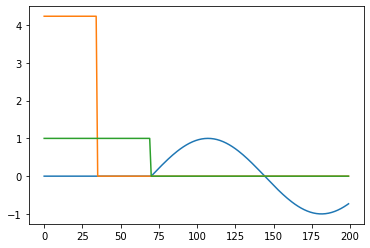

In [4]:
plt.plot(target[-1, :, 0].detach().numpy())
plt.plot(target[-1, :, 1].detach().numpy())
plt.plot(target[-1, :, 2].detach().numpy())